**Part 1 - Introducing the Mapping closure**

This notebook introduces the mapping closure developed by (Chen, H. 1989) and extended to higher dimensions by (Pope, S.B. 1991) and discusses how it can be applied to the problem of turbulent scalar mixing. In contrast to these works which consider a one-point pdf, ususally in the context of homogeneous isotropic turbulence, we consider the *global pdf* describing the contents of an arbitrary control volume.


**Content**

We first import all the packages we need to run this example

In [2]:
import numpy as np
import dedalus.public as d3
import h5py
import logging
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

**A) Scalar Mixing**

To motivate the problem, we consider the case of a passive scalar $Y(\mathbf{x},t)$ which evolves in a flow $\mathbf{U}(\mathbf{x},t)$ according to the advection-diffusion equation
\begin{equation}
\frac{\partial Y}{\partial t} + \mathbf{U} \cdot \nabla Y = \Gamma \nabla^2 Y,
\end{equation}
where $\Gamma$ is a scalar diffusvity, such that the CDF of the scalar field is given by
\begin{equation}
F(y,t) = \text{Prob} \{ Y(\mathbf{x},t) < y\},
\end{equation}
and its pdf by $f(y,t) = \partial_{y} F(Y , t)$. Below we show an example of the time evolution of $Y(\mathbf{x},t)$ and $f(y,t)$ in a 3D periodic box starting from the initial condition consisting of a sharp interface,
\begin{equation}
Y(\mathbf{x},t=0) = \tanh(10\mathbf{x}).
\end{equation}
*NOTE: This takes about 3 minutes to run.*

In [3]:
# Parameters
Γ  = 1;  # Equivalent to Peclet number
Nx = 32;   # This can be reduced but it will increase the noise in the histogram
stop_sim_time = 1
timestep = 1e-03

# Domain
coords = d3.CartesianCoordinates('x','y','z')
dist   = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)
ybasis = d3.RealFourier(coords['y'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)
zbasis = d3.RealFourier(coords['z'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)

# Fields
S = dist.Field(name='S', bases=(xbasis,ybasis,zbasis))
U = dist.VectorField(coords, name='U', bases=(xbasis,ybasis,zbasis))
x,y,z = dist.local_grids(xbasis,ybasis,zbasis)

A,B,C = 1,1,1;
# ABC flow
U['g'][0] = A*np.sin(z) + C*np.cos(y);
U['g'][1] = B*np.sin(x) + A*np.cos(z);
U['g'][2] = C*np.sin(y) + B*np.cos(x);

# Initial condition
S['g']    = np.tanh(10*(x + y + z))

# Problem
grad_S  = d3.grad(S)
problem = d3.IVP([S], namespace=locals())
problem.add_equation("dt(S) - Γ*div(grad_S) = -U@grad(S)") #

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Flow properties
snapshots = solver.evaluator.add_file_handler('snapshots', iter=1)
snapshots.add_task(S,      layout='g',name='S',scales=3/2)
snapshots.add_task(Γ*d3.div(grad_S), layout='g',name='Lap_S',scales=3/2)

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)

        if (solver.iteration-1) % (int(stop_sim_time/timestep) // 10) == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e'%(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2024-10-30 11:58:13,305 subsystems 0/1 INFO :: Building subproblem matrices 1/256 (~0%) Elapsed: 0s, Remaining: 10s, Rate: 2.5e+01/s
2024-10-30 11:58:13,821 subsystems 0/1 INFO :: Building subproblem matrices 26/256 (~10%) Elapsed: 1s, Remaining: 5s, Rate: 4.7e+01/s
2024-10-30 11:58:14,409 subsystems 0/1 INFO :: Building subproblem matrices 52/256 (~20%) Elapsed: 1s, Remaining: 4s, Rate: 4.5e+01/s
2024-10-30 11:58:15,138 subsystems 0/1 INFO :: Building subproblem matrices 78/256 (~30%) Elapsed: 2s, Remaining: 4s, Rate: 4.2e+01/s
2024-10-30 11:58:15,493 subsystems 0/1 INFO :: Building subproblem matrices 104/256 (~41%) Elapsed: 2s, Remaining: 3s, Rate: 4.7e+01/s
2024-10-30 11:58:15,888 subsystems 0/1 INFO :: Building subproblem matrices 130/256 (~51%) Elapsed: 3s, Remaining: 3s, Rate: 5.0e+01/s
2024-10-30 11:58:16,295 subsystems 0/1 INFO :: Building subproblem matrices 156/256 (~61%) Elapsed: 3s, Remaining: 2s, Rate: 5.1e+01/s
2024-10-30 11:58:16,724 subsystems 0/1 INFO :: Building subp

Having time integrated the transport equation for the scalar concentration we have a set of snapshots $Y(\mathbf{x},t)$ at discrete time intervals $t_n$. Loading the numerical snapshots saved below we show a 2D cross section of the scalar field and its corresponding PDF.

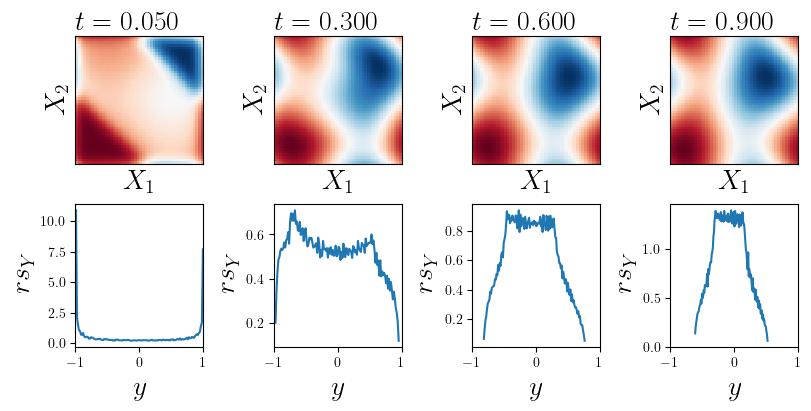

In [4]:
# Data loading
file   = h5py.File('./snapshots/snapshots_s1.h5', mode='r')
times  = file['tasks/S'].dims[0][0][:]
x_data = file['tasks/S'].dims[1][0][:]
y_data = file['tasks/S'].dims[2][0][:]
S_data = file['tasks/S'][:,...]

def PDF(S_data,t,N_bins=128):
  f,s= np.histogram(S_data[t,...].flatten(), bins=N_bins,density=True)
  s  = 0.5*(s[1:] + s[:-1]); ds = s[1] - s[0]
  #F = np.cumsum(f)*ds
  return s,f

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 4) ,layout="constrained")

for i,t in enumerate([50,300,600,900]):
  ax[0,i].pcolormesh(x_data, y_data, S_data[t,:,:,0],cmap='RdBu',norm='linear')
  ax[1,i].plot(PDF(S_data,t)[0],PDF(S_data,t)[1])
  ax[0,i].annotate(r'$t=%3.3f$'%times[t], xy=(0.0, 1.05), xycoords='axes fraction', fontsize=20)

for i in range(4):
  ax[0,i].set_aspect('equal')
  ax[0,i].set_xlabel(r'$X_1$', fontsize=20)
  ax[0,i].set_ylabel(r'$X_2$', fontsize=20)
  ax[0,i].set_yticks([])
  ax[0,i].set_xticks([])

  #ax[1,i].set_aspect(2)
  ax[1,i].set_xlabel(r'$y$', fontsize=20)
  ax[1,i].set_ylabel(r'$f_Y$', fontsize=20)
  ax[1,i].set_xlim([-1,1])


As shown above, the initial condition consisting of two scalar concentrations at $y = \pm 1$ is mixed thereby gradually transforming the pdf $f_Y$. We want to model this process directly in terms of the pdf $f_Y$.

**B) Evolution equation for the PDF**

Following [Pope et al. 1985](https://www.sciencedirect.com/science/article/abs/pii/0360128585900024) the evolution equation for these distributions is given by
\begin{equation}
\frac{\partial F}{\partial t} = \mathbb{E}_Y[ \Gamma \nabla^2 Y ] \frac{\partial F}{\partial y},
\end{equation}
and
\begin{equation}
\frac{\partial f}{\partial t} = \frac{\partial }{\partial y} \left( \mathbb{E}_Y[ \Gamma \nabla^2 Y ] f \right).
\end{equation}
As $f(y,t)$ contains no information about space this equation is unclosed as the conditional expectation is unknown, however we can apply the mapping closure developed by [Pope et al. 1991](https://link.springer.com/article/10.1007/BF00271466) to estimate a closure for the molecular mixing terms.

The idea behind this closure relies on Gaussian random fields. What makes these "random" fields particularly useful is:
- They are completely defined by their mean and covariance: 
\begin{equation}
    \mu = \mathbb{E}[\theta(\mathbf{z})], \quad \rho(r) = \mathbb{E}[\theta(\mathbf{z})\theta(\mathbf{z} + \mathbf{e}r)] - \mu^2,
\end{equation}
- Allow the calculate explicity the conditional expectation
\begin{equation}
lim_{r \to 0} \frac{\partial^2 \rho(r)}{\partial r^2} = \left\langle \frac{\partial \theta}{\partial z_i} \frac{\partial \theta}{\partial z_i} \right\rangle,
\end{equation}

and the fact that mutliple different field can have the same global PDF. Below we show and example of a Gaussian random field $\theta(\mathbf{z})$ with a $-5/3$ power-spectrum.


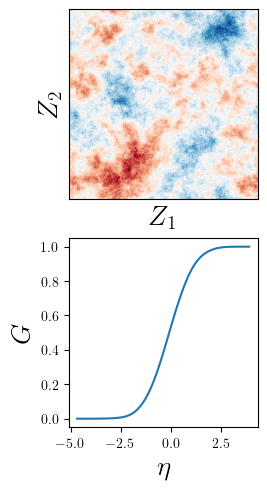

In [5]:
# Function to generate a Gaussian Random field
def gaussian_random_field(power_spectrum, shape = (128, 128), stat_real=False):
  """
  Generate a scale free Gaussian Random field Y(X) using the
  fast Fourier transform (FFT) and the power spectral density P(k)

  Y(x) = IFFT( P(k) * FFT(W(X)) )(X)

  where W(X) is a Gaussian white noise random field.

  Parameters
  ----------
  power_spectrum : (callable)
    Power spectral density P(k)
  shape : (int, int) G
    Grid size of the field generated

  Returns
  -------
  Y(X) : (array)
    Gaussian random field
  """
  if not callable(power_spectrum):
    raise Exception("`power_spectrum` should be callable")

  def statistic(shape):
    # Build a unit-distribution of complex numbers with random phase
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b

  # Compute the k grid
  fftfreq = np.fft.fftfreq
  all_k = [fftfreq(s, d=1/s) for s in shape]
  kgrid = np.meshgrid(*all_k, indexing="ij")  # Reutrns kX, kY
  knorm = np.sqrt(np.sum(np.power(kgrid, 2), axis=0))  # Computes ||k|| = \sqrt{kX^2 + kY^2}

  # (1) Compute the Fourier transform of Gaussian White noise W(X)
  if stat_real:
    W = statistic(shape)
    # Compute the FFT of the field
    FW = np.fft.fftn(W)
  else:
    # Draw a random sample in Fourier space
    fourier_shape = knorm.shape
    FW = statistic(fourier_shape)

  # (2) Multiply by P(k)^{1/2}
  power_k = np.zeros_like(knorm)
  mask = knorm > 0
  power_k[mask] = np.sqrt(power_spectrum(knorm[mask]))
  FW *= power_k

  # (3) Take its IFFT
  return  np.real(np.fft.ifftn(FW))

# Create an example
n_pts = 512
power_spectrum = lambda k: k**-3
shape = (n_pts, n_pts)

Z_1 = np.linspace(-np.pi,np.pi,num=n_pts)
Z_2 = np.linspace(-np.pi,np.pi,num=n_pts)
Ys = gaussian_random_field(power_spectrum, shape) # Ys for Y surrogate

# Plot Z(z) and F_Z
fig, (ax0,ax1) = plt.subplots(nrows=2, ncols=1, layout="constrained")

# plot Ys(Z) as a field
cmap = plt.get_cmap('RdBu')
ax0.pcolormesh(Z_1, Z_2, Ys, cmap=cmap)
ax0.set_xlabel(r'$Z_1$', fontsize=20)
ax0.set_ylabel(r'$Z_2$', fontsize=20)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_box_aspect(1)

# plot its cdf by averaging over realisations
Ys = []
for i in range(64):
  Ys_i = gaussian_random_field(power_spectrum, shape)
  Ys.append(Ys_i.flatten())
Ys = np.concatenate(Ys).flatten()

sigma = np.std(Ys)
mean = np.mean(Ys)

Ys = (Ys - mean)/sigma

f,s= np.histogram(Ys, bins=64, density=True)
s  = 0.5*(s[1:] + s[:-1]); ds = s[1] - s[0]
F = np.cumsum(f)*ds
ax1.plot(s, F)
ax1.set_xlabel(r'$\eta$', fontsize=20)
ax1.set_ylabel(r'$G$', fontsize=20)
ax1.set_box_aspect(1)

plt.show()

**C) Mapping Closure**

Based on the properties of the Gaussian random field the idea is therefore to find a mapping 
\begin{equation}
\tilde{Y}(\mathbf{x},t) = \mathscr{Y}(\theta(\mathbf{x} J(t)),t),
\end{equation}
such that we can express the CDF $F$ in terms of the cumulative Gaussian $G$ 
\begin{equation}
F(\mathscr{Y}(\eta,t),t) = G(\eta).
\end{equation}

Differentiating the last equation we obtain
\begin{equation}
\frac{ \partial F}{\partial t} = \frac{ \partial \mathscr{Y}}{\partial t} \frac{ \partial F}{\partial y}.
\end{equation}
which can then be expressed as
\begin{equation}
\frac{\partial \mathscr{Y}}{\partial t} = \mathbb{E}_Y[ \Gamma \nabla^2 Y ] = \Gamma \frac{J^2(t)}{\lambda_{\theta}^2} \left( -\eta \mathscr{Y}'(\eta,t) + \mathscr{Y}''(\eta,t) \right).
\end{equation}

**D) Application to scalar mixing**

As a test of this method we consider the mixing of the initial condition $Y(\mathbf{x},t=0)$ consisting of blobs of fluid at $y = \pm 1$ such that
\begin{equation}
f(y,t=0) = 1/2[ \delta(y-1)+ \delta(y+1)],
\end{equation}
and
\begin{equation}
\mathscr{Y}(\eta,t=0) = 2H(\eta,0) - 1.
\end{equation}

Below we numerically solve the mapping's parabolic evolution equation derived above subject to the Neumann boundary conditions $\partial_{\eta} \mathscr{Y} = 0$ at $\pm \infty$ or numerically the limits of the finite domain. Solving this equation we obtain a numerical approximation $\mathscr{Y}(\eta_i,t_n)$ on the sample space $\eta_n$ and time $t_i$ grids.

In [11]:
def Derivatives(N,dx):

  D = np.zeros((N,N))
  for i in range(N):
    if i < N-1:
      D[i,i+1] = 1
    if i > 0:
      D[i,i-1] =-1

  L = np.zeros((N,N))
  for i in range(N):

    L[i,i] = -2.
    if i ==N-1:
      L[i,i-1] = 2
      #L[i,i-1] = 1
    elif i == 0:
      L[i,i+1] = 2
      #L[i,i+1] = 1
    else:
      L[i,i-1] = 1
      L[i,i+1] = 1

  return D/(2*dx), L/(dx**2)

def Map_Solver(X_0, η,dη, T,Δt, J = lambda t: 1):

  N_η = len(η)
  N_T = len(T)

  D_η, L_η  = Derivatives(N_η,dη)
  L         = -np.diag(η)@D_η + L_η
  I         = np.eye(L.shape[0])

  A = lambda t: I/Δt - J(t)*L/2
  B = lambda t: I/Δt + J(t)*L/2

  X      = np.zeros((N_T,N_η))
  X[0,:] = X_0
  for n,t in enumerate(T[:-1]):
    X[n+1,:] = np.linalg.solve(A(t),B(t)@X[n,:])
    # plt.plot(η,X[n,:])
    # plt.show()

  return X;

# Domain
N_η  = 256
N_T  = 10**3
η,dη = np.linspace(-2,2,N_η,retstep=True);
T,Δt = np.linspace( 0,1,N_T,retstep=True);

# Initial condition
X_0 = 2*np.heaviside(η,0) - 1

# Solve
X   = Map_Solver(X_0, η,dη, T,Δt, J = lambda t: 1)

Having solved for $\mathscr{Y}(\eta_n,t_i)$ we then use this to recover the CDF by differentiating
\begin{equation}
\partial_{\eta} \left( F(\mathscr{Y}(\eta,t),t) - G(\eta) \right) = f(\mathscr{Y}(\eta,t),t) \frac{\partial \mathscr{Y}}{\partial \eta} - g(\eta) = 0,
\end{equation}
and rearranging in terms of $f$ to obtain
\begin{equation}
f(\mathscr{Y}(\eta,t),t)  = g(\eta)/ \frac{\partial \mathscr{Y}}{\partial \eta}.
\end{equation}
Below we plot the time evolution of $f(\mathscr{Y}(\eta,t),t)$ recovered in this manner as well as integrating it over sample space to check it defines a pdf.

int f dx =  0.9527477841871262
int f dx =  0.9527644143739532
int f dx =  0.9527722754436889
int f dx =  0.9527739699381969


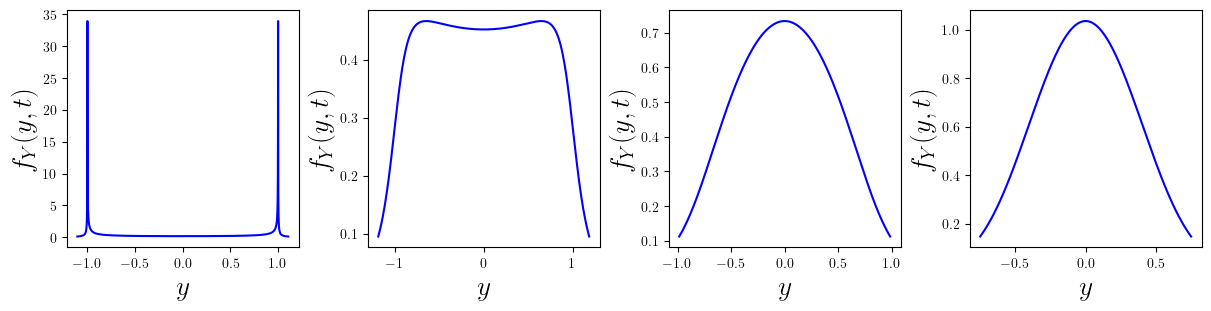

In [15]:
# Create the map from X to f
D_η, L_η  = Derivatives(N_η,dη)
dXdη = ( D_η@(X.T) ).T
g    = lambda η: (1./np.sqrt(2*np.pi) )*np.exp(-.5*(η**2))
f    = lambda n: g(η[1:-1])/dXdη[n,1:-1]

# Plot
fig, ax = plt.subplots(ncols=4, figsize = (12, 3), layout="constrained")

for i,n in enumerate([50,300,600,900]):
    ax[i].plot(X[n,1:-1],f(n),'b-')
    ax[i].set_ylabel(r'$f_Y(y,t)$',fontsize=20)

    # check integral constraint int f dx = 1
    print('int f dx = ',np.trapz(f(n),X[n,1:-1]) )

for axs in ax:
    axs.set_xlabel(r'$y$',fontsize=20)
    #axs.set_xlim([-1.1, 1.1])

plt.show()

Comparing this figure with the simulation output we see that the essential physics of the mixing is captured, whereby as the scalar field homogenises, the bimodal distribution tends towards a Dirac measure.

**Appendix A) Generating a Gaussian Random field** 


CAUTION: SECTION NOT FINISHED\\


A stationary isotropic Gaussian random field $\tilde{Y}(\mathbf{x})$ defined on a 2D domain $\Omega$ is a random function completely specified by its mean and covariance
\begin{align*}
\mu  &= \mathbb{E}[\tilde{Y}(\mathbf{x})], \\
C(||\delta \mathbf{x}||) &= \mathbb{E}[\tilde{Y}(\mathbf{x}) \tilde{Y}(\mathbf{x} + \delta \mathbf{x})] - \mu^2,
\end{align*}
where by stationarity $\mathbf{x}$ can be chosen aribtrarily and by isotropy $C$ depends only on the distance $||\delta \mathbf{x}||$. In addition this function has the following properies:
- The random variable $Y_i = Y(\mathbf{x}_i)$ (corresponding to an evaluation of $Y$ at $X_i$) is normally distributed.
- The vector of random variables $\mathbf{Y} = [Y_1, Y_2, \cdots, Y_n]$ consisting on $n$ point evaluations is joint normal.

Letting $r = ||\delta \mathbf{x}||$ we can relate the covariance $C$ to the power spectral density
\begin{equation}
P(\mathbf{k}) = \int e^{i \langle \mathbf{k} , \delta \mathbf{x} \rangle} C(||\delta \mathbf{x}||) d \delta \mathbf{x},
\end{equation}
using the [Hankel-transform](https://en.wikipedia.org/wiki/Hankel_transform). As number of covariance and power-spectrum pairs can be computed analytically we will use this for verification of our numerical implementation of our Gaussian random field generating function.

To generate $\tilde{Y}(\mathbf{x}) \in \mathbb{R}^d$ we make use of $W(\mathbf{x}) \in \mathbb{C}^d$ a Gaussian White noise random field such that $\mathbb{E}[W(x)W(y)] = \delta(x-y)$. Letting the Fourier transform of this white noise process be defined as
\begin{equation}
FW(k) \equiv F \circ W(x) = \int_{\mathbb{R}^d} e^{2 \pi i (k,x)} W(x) dx,
\end{equation}
we can then write
\begin{equation}
\tilde{Y}(x) = (F^{-1} P^{1/2} F W)(x),
\end{equation}
where $P(k)$ is the power spectrum of the correlation function as defined above. Below we implement two examples using the scale free power law spectrum $P(k) = |k|^{-\alpha}$. As the power spectrum that falls off like a power law and the structures in these fields are typically fractal they do not distinguish any particular length scale.

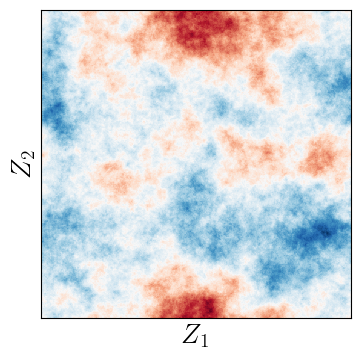

In [16]:
# Create an example
n_pts = 512
power_spectrum = lambda k: k**-3
shape = (n_pts, n_pts)

Z_1 = np.linspace(-np.pi,np.pi,num=n_pts)
Z_2 = np.linspace(-np.pi,np.pi,num=n_pts)
Ys = gaussian_random_field(power_spectrum, shape) # Ys for Y surrogate

# plot Ys(Z) as a field
plt.figure(figsize=(4,4))
cmap = plt.get_cmap('RdBu')
plt.pcolormesh(Z_1, Z_2, Ys, cmap=cmap)
plt.xlabel(r'$Z_1$', fontsize=20)
plt.ylabel(r'$Z_2$', fontsize=20)
plt.xticks([])
plt.yticks([])
plt.show()


Next we validate our implementation. To do so we specify the correlation function
\begin{equation}
C(||\delta \mathbf{x}||) = r, %e^{\frac{-1}{2} r^2},
\end{equation}
for which the power spectrum is given by
\begin{equation}
P(\mathbf{k}) = \int e^{i \langle \mathbf{k} , \delta \mathbf{x} \rangle} C(||\delta \mathbf{x}||) d \delta \mathbf{x} = -\frac{1}{k^3}.
\end{equation}
We then generate a field with this power spectrum and compare its computed covariance with the analytical expression.

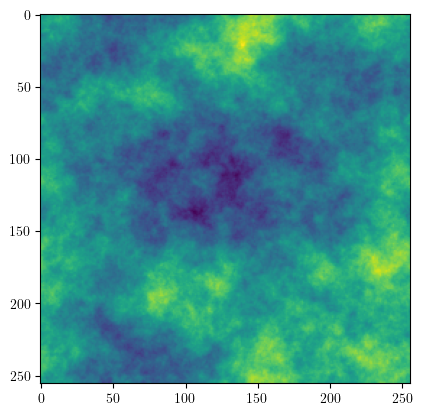

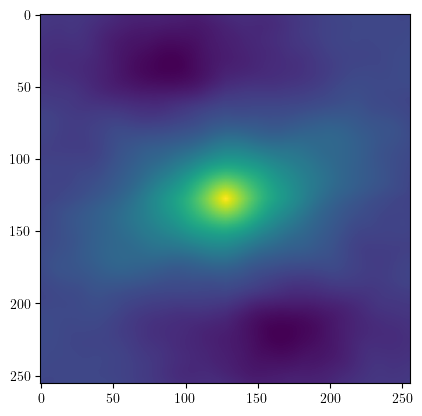

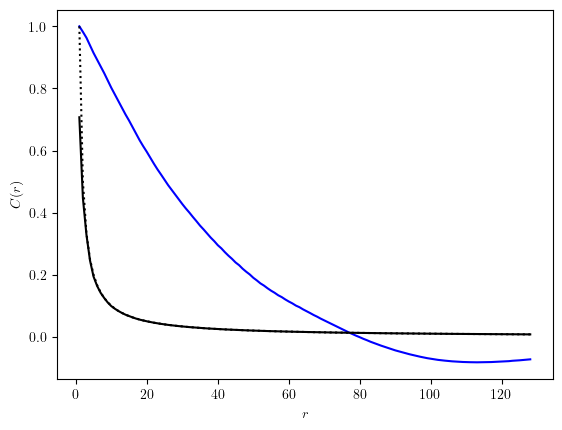

In [17]:
# 1) Generate a field
n_pts = 256
power_spectrum = lambda k: 1/k**3#np.exp(-.5*k**2)
shape = (n_pts, n_pts)
Ys = gaussian_random_field(power_spectrum, shape) # Ys for Y surrogate
plt.imshow(Ys)
plt.show()

# 2) Compute the covariance
from scipy.signal import correlate
C = correlate(Ys,Ys,mode='same',method='auto')
plt.imshow(C)
plt.show()

# 3) Compute the error

indx = np.zeros(n_pts)
indx[0:n_pts//2] = np.arange(-n_pts//2,0,1)
indx[n_pts//2:] = np.arange(1,n_pts//2+1,1)

# create array of radii
x,y = np.meshgrid(indx,indx)
R = np.sqrt(x**2 + y**2)

C_anal = 1/R

# calculate the mean
r  = np.linspace(1,n_pts//2,num=n_pts//2)
f = lambda r : C[(R >= r-.5) & (R < r+.5)].mean()
mean_num = np.vectorize(f)(r)
f = lambda r : C_anal[(R >= r-.5) & (R < r+.5)].mean()
mean_anal = np.vectorize(f)(r)
# plot it
fig,ax=plt.subplots()
ax.plot(r,mean_num/mean_num[0],'b-')
ax.plot(r,mean_anal,'k') # Analytical
ax.plot(r,1/r,'k:') # Analytical

ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$C(r)$')
plt.show()

In addiation to the brief overview given here some nice texts on this topic are [1](https://structures.uni-heidelberg.de/blog/posts/gaussian-random-fields/index.php) and [2](https://arxiv.org/pdf/1105.2737).